# Ficheux-like gate between a transmon and a fluxonium: leakage analysis
In this notebook we study leakage in the two-qubit gate between a transmon and a fluxonium inspired by the two-qubit gate between a transmon and a fluxonium described in Ficheux et al. Phys. Rev. X 11, 021026 (2021). See notebook "gate_setup_and_fidelity.ipynb" for more details about the gate principle.

In [35]:
import numpy as np
import time
import qutip as qtp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import List, Dict, Callable
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'cm'
import util_ficheux_inspired_gate as util

import pysqkit
from pysqkit.util.metrics import average_process_fidelity, \
    average_gate_fidelity
from pysqkit.util.phys import temperature_to_thermalenergy
from pysqkit.util.quantum import generalized_rabi_frequency
from pysqkit import QubitSystem
from pysqkit.solvers.solvkit import integrate
import pysqkit.util.transformations as trf

from IPython.display import display, Latex


From a first analysis it seems that leakage is mainly due to incoherent processes in the fluxonium. In fact, adding relaxation to the fluxonium highly increases the leakage. 

In [49]:
temperature = 0.020 # K
thermal_energy = temperature_to_thermalenergy(temperature) # kb T/h in GHz
d_comp = 4

#Transmon
levels_t = 3
transm = pysqkit.qubits.SimpleTransmon(
    label='T', 
    max_freq=4.5, 
    anharm=-0.3,
    diel_loss_tan=0.75*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy,    
    dim_hilbert=levels_t
)

#Fluxonium
levels_f = 5
ec_f = .973
el_f = .457
ej_f = 8.0
# The external flux in units of \phi_0 is set to 1/2 by defauls:
# double well configuration

flx = pysqkit.qubits.Fluxonium(
    label='F', 
    charge_energy=.973, 
    induct_energy=.457, 
    joseph_energy=8.0, 
    diel_loss_tan=7.1*1e-6, #set to zero to check d_1 L1 = d_2 L2
    env_thermal_energy=thermal_energy
)
flx.diagonalize_basis(levels_f)

# We also add a drive on the fluxonium
flx.add_drive(
    pysqkit.drives.microwave_drive,
    label='cz_drive_f',
    pulse_shape=pysqkit.drives.pulse_shapes.gaussian_top
)

d_leak = levels_t*levels_f - d_comp

jc = 0.07
coupled_sys = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=jc)
bare_system = transm.couple_to(flx, coupling=pysqkit.couplers.capacitive_coupling, strength=0.0)

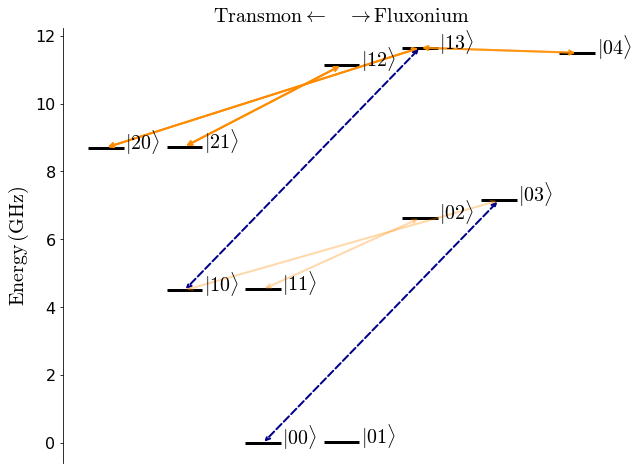

In [50]:
level_list = ['00', '01', '10', '11', '02', '20', '12','21', '03', '13', '04']

util.energy_levels_diagram(bare_system, level_list)

The figure shows the energy of the bare levels. The orange arrows indicate the non-zero matrix elements between the (bare) levels provided by the capacitive coupling $V$: the more shaded the arrow the weaker the coupling. The idea is to design the system so that the $| 1 3 \rangle$-$|0 4 \rangle$ is close to resonance so that the levels get sufficiently hybridized. A CZ gate can then be realized by driving the $|0 \rangle$-$|3 \rangle$ transition of the fluxonium, which induces transitions depicted by the blue, dashed arrow in the figure. The scheme is inspired by the one between two fluxonia described in Ficheux et al. Phys. Rev. X 11, 021026 (2021), where the $|2 1  \rangle$ and $|12 \rangle$ levels are hybridized and the transition $| 1 \rangle$-$|2 \rangle$ of one of the two fluxonia is driven.

We look at the following quantities : 

$$\zeta_{ZZ} = E_{00} + E_{11} - E_{01} - E_{10}$$
$$\Delta = \left( E_{13} - E_{10} \right) -  \left( E_{03} - E_{00} \right)$$

The $\Delta$ is similar at the one in Ficheux but looking at the 0-3 transition of the Fluxonium.

For the given parameters we have

In [51]:
display(Latex(r'$\xi_{{ZZ}}/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.zz(coupled_sys))))
display(Latex(r'$\Delta/h = {:.3f} \, \mathrm{{MHz}}$'.format(1e3*util.delta(coupled_sys))))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

## Matching the parameters
For this case we look at the 10-13 and 00-03 transitions so we process the corresponding Rabi frequencies :

$$\Omega_{10-13}  = \left| \epsilon_T \langle 10 | \hat{n}_T | 13 \rangle + \epsilon_F \langle 10 | \hat{n}_F | 13 \rangle \right|$$
$$\Omega_{00-03}  = \left| \epsilon_T \langle 00 | \hat{n}_T | 03 \rangle + \epsilon_F \langle 00 | \hat{n}_F | 03 \rangle \right|$$

And then :
$$r = \dfrac{\Omega_{10-13}}{\Omega_{00-03}} \text{  and  } \dfrac{\delta}{\Delta} = \dfrac{r^2 - \sqrt{(r^2-1)^2 + r^2 }} {r^2 - 1}$$ 

With these conventions taken in the paper :
$$\Delta = f_{10-13} - f_{00-03}$$
$$\delta = f_{10-13} - f_d$$

These conventions are taken in orde to have : $\Omega = \sqrt{\Omega_{10-13}^2  + \delta^2} = \sqrt{\Omega_{00-03}^2  + (\delta - \Delta)^2}$

The $\Delta$ is fixed by the parameters of the qubits, we now need to settle the values for the drive parameters.

First we need to fix the $\varepsilon$.

We take the condition of the paper :
$$\Omega = \Delta$$

However, one equation for two parameters is not enough. We assume that the fluxonium is driven much more than the transmon (as we are mainly looking at the 0-3 transtion of F) and, in general, we could take the drive on the transmon to be a fixed fraction of the one on the fluxonium. In what follows we simply set the drive on the transmon to be zero. Now we have enough constraints to find values for every parameters.


With this $\delta$, we have $\Omega = \Delta$ and a CZ gate is achieved with zero leakage in time exactly $t_{drive} = 1/\Delta$.

In order to setup the optimization define the following function that respects the scipy.optimize.minimize syntax. The vector of variable x0 in this case has length 2: the first entry is a reference drive strength, while the second the drive frequency. The drive parameters for each qubit are defined by providing the ratio between the qubit drive strength and the reference drive strength. This can be used to take into account potential classical crosstalk.

In [52]:
# x0 = np.array([0.03, 7.15]) #initial guess
# eps_ratios = {'T': 0.0, 'F':1.0}
# args_to_pass = (['00', '03'], ['10', '13'], coupled_sys, eps_ratios) 

# start = time.time()

# minimization_result = minimize(util.func_to_minimize, x0, args=args_to_pass)

# end = time.time()

# display(Latex(r'$\mathrm{{Minimization \, time}} = {:.3f} \, s$'.format(end - start)))

In [53]:
# display(Latex(r'$y_{{\mathrm{{min}}}} = {:.2e}$'.format(minimization_result['fun'])))
# display(Latex(r'$\epsilon_{{\mathrm{{d, opt}}}} = {:.7f}$'.format(minimization_result['x'][0])))
# display(Latex(r'$f_{{\mathrm{{d,opt}}}} = {:.5f} \, \mathrm{{GHz}}$'.format(minimization_result['x'][1])))

In [54]:
eps_drive = 0.03100 #minimization_result['x'][0] #  #
freq_drive = 7.155 #minimization_result['x'][1] #  #minimization_result['x'][1]
rabi_period = 1/util.delta(coupled_sys)
t_rise = 15.0 # [ns]
t_tot = 60    # [ns]
pts_per_drive_period = 5 

nb_points = int(t_tot*freq_drive*pts_per_drive_period)
tlist = np.linspace(0, t_tot, nb_points)

coupled_sys['F'].drives['cz_drive_f'].set_params(phase=0, time=tlist, rise_time=t_rise, 
                                                 amp=eps_drive, freq=freq_drive)

In [55]:
simu_opt = qtp.solver.Options()
simu_opt.atol = 1e-12
simu_opt.rtol = 1e-10

In what follows we are interested in studying leakage out of the computational subspace that we here define

In [56]:
state_labels = ['00', '01', '10', '11']
comp_states = []
for label in state_labels:
    comp_states.append(coupled_sys.state(label)[1])

In [57]:
def run(
    time: np.ndarray,
    system: QubitSystem, 
    state_init:qtp.qobj.Qobj, 
    options: qtp.solver.Options=None
):
    hamil0 = system.hamiltonian(as_qobj=True)
    hamil_drive = []
    pulse_drive = []
                    
    for qubit in system:
        if qubit.is_driven:
            for label, drive in qubit.drives.items():
                hamil_drive.append(drive.hamiltonian(as_qobj=True))
                pulse_drive.append(drive.eval_pulse())
    jump_op = [op for qubit in system for op in qubit.collapse_ops(as_qobj=True)]
                    
    result = integrate(time, state_init, hamil0, hamil_drive,
                           pulse_drive, jump_op , "mesolve", options=options)
                    
    return result   

In [58]:
start = time.time()

_proj_comp = np.einsum('ai, aj -> ij', comp_states, np.conj(comp_states))
subsys_dims = list(q.dim_hilbert for q in coupled_sys)
proj_comp = qtp.Qobj(inpt=_proj_comp, dims=[subsys_dims, subsys_dims], isherm=True)
res = run(time=2*np.pi*tlist, system=coupled_sys, state_init=proj_comp/d_comp, options=simu_opt)

end=time.time()
display(Latex(r'$\mathrm{{Leakage \, computation \, time}} = {:.3f} \, s$'.format(end - start)))
l1 = 1 - qtp.expect(proj_comp, res.states[-1])

<IPython.core.display.Latex object>

In [59]:
leakage_states = ['13', '03', '04', '12']

In [60]:
def get_probabilities(
    states_label: List[str], 
    system:QubitSystem, 
    final_state: qtp.qobj.Qobj
) -> Dict:
    prob = {}
    for label in states_label:
        ket = system.state(label, as_qobj=True)[1]
        projector = ket*ket.dag()
        prob[label] = qtp.expect(projector, final_state)
    return prob
    

In [61]:
leak_probs = get_probabilities(leakage_states, coupled_sys, res.states[-1])

display(Latex(r'$\mathrm{{Average\, Leakage \,}} L_1 = {:.7f} $'.format(l1)))

sum_leak = 0

for label in leakage_states:
    display(Latex(r'$P_{{leak, {}  }} = {:.7f}$'.format(label, leak_probs[label])))
    sum_leak += leak_probs[label]
display(Latex(r'$\sum_k P_{{leak, k  }} = {:.7f}$'.format(sum_leak)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>